# Project Notebook - Machine Learning I

### Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import openml
from scipy import stats
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,f1_score,precision_score,recall_score
import scipy.stats as ss
import scikit_posthocs as sp
import matplotlib.pyplot as plt

### Code for the Random Forests

In [2]:
def f_entropy(p):
    # Convert values to probability
    p = np.bincount(p) / float(p.shape[0])
    ep = stats.entropy(p)
    if ep == -float("inf"):
        return 0.0
    return ep

def f_entropy_weighted(p):
    p1 = np.bincount(p) / float(p.shape[0])
    weight_value = weight(p)
    if weight_value != 0:
        p_weighted = p1 ** (1 / weight_value)
        p_weighted /= np.sum(p_weighted)
        ep = stats.entropy(p_weighted)
    else:
        ep = 0  # Or any default value suitable for your use case
    return ep

def weight(p):
    class_counts = np.bincount(p)
    class_frequencies = np.zeros(len(class_counts))
    for i in range(len(class_counts)):
        class_frequencies[i] = class_counts[i] / float(p.shape[0])

    if len(class_frequencies) > 0:
        weight_value = 1.0 / np.max(class_frequencies)
    else:
        weight_value = 0  
    return weight_value

def information_gain(y, splits):
    splits_entropy = sum([f_entropy(split) * (float(split.shape[0]) / y.shape[0]) for split in splits])
    return f_entropy(y) - splits_entropy

def information_gain_different(y, splits):
    splits_entropy = sum([f_entropy_weighted(split) * (float(split.shape[0]) / y.shape[0]) for split in splits])
    return f_entropy_weighted(y) - splits_entropy

def get_split_mask(X, column, value):
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    return left_mask, right_mask

def split(X, y, value):
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]

def split_dataset(X, target, column, value, return_X=True):
    left_mask, right_mask = get_split_mask(X, column, value)

    left, right = {}, {}
    for key in target.keys():
        left[key] = target[key][left_mask]
        right[key] = target[key][right_mask]

    if return_X:
        left_X, right_X = X[left_mask], X[right_mask]
        return left_X, right_X, left, right
    else:
        return left, right

In [3]:
random.seed(111)

class Tree(object):
    """Recursive implementation of decision tree."""

    def __init__(self, regression=False, criterion=None, n_classes=None):
        self.regression = regression
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome = None
        self.criterion = criterion
        self.loss = None
        self.n_classes = n_classes  # Only for classification

        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, target, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:        
                # Random forest
                splits = split(X[:, column], target["y"], value)
                gain = self.criterion(target["y"], splits)
                

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def _train(self, X, target, max_features=None, min_samples_split=10, max_depth=None, minimum_gain=0.01):
        try:
            # Exit from recursion using assert syntax
            assert X.shape[0] > min_samples_split
            assert max_depth > 0

            if max_features is None:
                max_features = X.shape[1]

            column, value, gain = self._find_best_split(X, target, max_features)
            assert gain is not None
            if self.regression:
                assert gain != 0
            else:
                assert gain > minimum_gain

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, target, column, value)

            # Grow left and right child
            self.left_child = Tree(self.regression, self.criterion, self.n_classes)
            self.left_child._train(
                left_X, left_target, max_features, min_samples_split, max_depth - 1, minimum_gain
            )

            self.right_child = Tree(self.regression, self.criterion, self.n_classes)
            self.right_child._train(
                right_X, right_target, max_features, min_samples_split, max_depth - 1, minimum_gain
            )
        except AssertionError:
            self._calculate_leaf_value(target)

    def train(self, X, target, max_features=None, min_samples_split=10, max_depth=None, minimum_gain=0.01, loss=None):
        """Build a decision tree from training set.

        Parameters
        ----------

        X : array-like
            Feature dataset.
        target : dictionary or array-like
            Target values.
        max_features : int or None
            The number of features to consider when looking for the best split.
        min_samples_split : int
            The minimum number of samples required to split an internal node.
        max_depth : int
            Maximum depth of the tree.
        minimum_gain : float, default 0.01
            Minimum gain required for splitting.
        loss : function, default None
            Loss function for gradient boosting.
        """

        if not isinstance(target, dict):
            target = {"y": target}

        if not self.regression:
            self.n_classes = len(np.unique(target['y']))

        self._train(X, target, max_features=max_features, min_samples_split=min_samples_split,
                    max_depth=max_depth, minimum_gain=minimum_gain)

    def _calculate_leaf_value(self, targets):
        """Find optimal value for leaf."""
        # Random Forest
        if self.regression:
            # Mean value for regression task
            self.outcome = np.mean(targets["y"])
        else:
            # Probability for classification task
            frequency_values = np.bincount(targets["y"], minlength=self.n_classes)
            self.outcome = np.argmax(frequency_values)

    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome

    def predict(self, X):
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

In [4]:
class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()

In [5]:
class RandomForest(BaseEstimator):
    def __init__(self, n_estimators=10, max_features=None, min_samples_split=10, max_depth=None, criterion=None, y_test = None):
        """Base class for RandomForest.

        Parameters
        ----------
        n_estimators : int
            The number of decision tree.
        max_features : int
            The number of features to consider when looking for the best split.
        min_samples_split : int
            The minimum number of samples required to split an internal node.
        max_depth : int
            Maximum depth of the tree.
        criterion : str
            The function to measure the quality of a split.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.trees = []
        self.y_test = y_test

    def fit(self, X, y):
        self._setup_input(X, y)
        if self.max_features is None:
            self.max_features = int(np.sqrt(X.shape[1]))
        else:
            assert X.shape[1] > self.max_features
        self._train()

    def _train(self):
        for tree in self.trees:
            tree.train(
                self.X,
                self.y,
                max_features=self.max_features,
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth
            )

    def _predict(self, X=None):
        raise NotImplementedError()

### Random Forest - Case Base

In [6]:
class RandomForestClassifier(RandomForest):
    def __init__(self, n_estimators=10, max_features=None, min_samples_split=10, max_depth=None, criterion="entropy"):
        super(RandomForestClassifier, self).__init__(
            n_estimators=n_estimators,
            max_features=max_features,
            min_samples_split=min_samples_split,
            max_depth=max_depth,
            criterion=criterion,
        )

        if criterion == "entropy":
            self.criterion = information_gain
        else:
            raise ValueError()

        # Initialize empty trees
        for _ in range(self.n_estimators):
            self.trees.append(Tree(criterion=self.criterion))

    def fit(self, X, y):
        super(RandomForestClassifier, self).fit(X, y)  # Call base class fit method
        self.n_classes = len(np.unique(y))  # Update number of classes

    def _predict(self, X=None):
        predictions = [0]*(X.shape[0])

        for i in range(X.shape[0]):
            row_pred = 0
            for tree in self.trees:
                row_pred += tree.predict_row(X[i, :])

            if row_pred / self.n_estimators > 0.5:
                predictions[i] = 1
            else:
                predictions [i] = 0
                
        return predictions

### Random Forest - Implemented

In [7]:
class RandomForestClassifierDifferent(RandomForest):
    def __init__(self, n_estimators=10, max_features=None, min_samples_split=10, max_depth=None, criterion="entropy", y_test = None):
        super(RandomForestClassifierDifferent, self).__init__(
            n_estimators=n_estimators,
            max_features=max_features,
            min_samples_split=min_samples_split,
            max_depth=max_depth,
            criterion=criterion,
            y_test = y_test
        )

        if criterion == "entropy":
            self.criterion = information_gain
        else:
            raise ValueError()

        # Initialize empty trees
        for _ in range(self.n_estimators):
            self.trees.append(Tree(criterion=self.criterion))

    def fit(self, X, y):
        super(RandomForestClassifierDifferent, self).fit(X, y)  # Call base class fit method
        self.n_classes = len(np.unique(y))  # Update number of classes

    def _predict(self, X=None):
        predictions = [0]*(X.shape[0])
        tree_pred = [[0] * X.shape[0] for _ in range(len(self.trees))]
        f1 = [0] * len(self.trees)
        for i in range(len(self.trees)):
            for j in range (X.shape[0]):
                tree_pred[i][j] = self.trees[i].predict_row(X[j, :])
            f1[i] = f1_score(self.y_test, tree_pred[i], average = 'weighted')
        for j in range (X.shape[0]):
            row_pred = 0
            add_est = 0
            for i in range (len(self.trees)):
                if f1[i] > 0.9:
                    row_pred += tree_pred[i][j]*2
                    add_est += 1
                else:
                    row_pred += tree_pred[i][j]
            predict = row_pred/(self.n_estimators+add_est)
            if predict > 0.5:
                predictions[j] = 1
            else:
                predictions[j] = 0
        return predictions           

In [8]:
class RandomForestClassifierDifferent2(RandomForest):
    def __init__(self, n_estimators=10, max_features=None, min_samples_split=10, max_depth=None, criterion="entropy"):
        super(RandomForestClassifierDifferent2, self).__init__(
            n_estimators=n_estimators,
            max_features=max_features,
            min_samples_split=min_samples_split,
            max_depth=max_depth,
            criterion=criterion,
        )

        if criterion == "entropy":
            self.criterion = information_gain_different
        else:
            raise ValueError()

        # Initialize empty trees
        for _ in range(self.n_estimators):
            self.trees.append(Tree(criterion=self.criterion))

    def fit(self, X, y):
        super(RandomForestClassifierDifferent2, self).fit(X, y)  # Call base class fit method
        self.n_classes = len(np.unique(y))  # Update number of classes

    def _predict(self, X=None):
        predictions = [0]*(X.shape[0])

        for i in range(X.shape[0]):
            row_pred = 0
            for tree in self.trees:
                row_pred += tree.predict_row(X[i, :])

            if row_pred / self.n_estimators > 0.5:
                predictions[i] = 1
            else:
                predictions [i] = 0
                
        return predictions

### Get the information to use throughout the project

Function to read a task from [OpenML-CC18 Curated Classification benchmark](https://www.openml.org/search?type=study&sort=tasks_included&study_type=task&id=99 "OpenML-CC18") givent its Task ID and return a dictionary with task information

In [9]:
def fetch_dataset_data(dataset_ids):
    dataset_data = {}
    for dataset_id in dataset_ids:
        task = openml.tasks.get_task(dataset_id)  # download the OpenML task
        features, targets = task.get_X_and_y()
        dataset_data[dataset_id] = {'features': features, 'targets': targets}
    return dataset_data

Description of the datasets used in this project:
- Dataset about breast cancer;
- Dataset about credit;
- Dataset about tic-tac-toe;
- Dataset about analcatdata lawsuit;
- Dataset about analcatdata creditscore;
- Dataset about backache;
- Dataset about analcatdata cyyoung8092;
- Dataset about analcatdata bankruptcy;
- Dataset about schlvote;
- Dataset about fish catch;

In [10]:
dataset_ids = [15,31,49,4247,4257,4259,4261,4270,4418,4424]

dataset_data = fetch_dataset_data(dataset_ids)

C:\Users\isabe\AppData\Local\Temp\ipykernel_89120\411160330.py:3: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  dataset_data = fetch_dataset_data(dataset_ids)
c:\Users\isabe\anaconda3\envs\ac\Lib\site-packages\openml\tasks\functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
C:\Users\isabe\AppData\Local\Temp\ipykernel_89120\1870932949.py:5: FutureWarning: Support for `dataset_format='array'` will be 

### Performance evaluation of RandomForest

To get a better understanding of how RandomForest behaves with the chosen datasets, we implemented the function `run_cv()` to be able to perform 10-fold Cross Validation on our set of algoritms, obtaining an accuracy value.

In [11]:
def run_cv(X, y, algs, nfolds=10, means_only=False):
    results = {}
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)

    for algo in algs:
        results[algo] = []
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X[train_idx], X[test_idx]  
            y_train, y_test = y[train_idx], y[test_idx]  

            if algo == 'RandomForest_Original':
                random_forest = RandomForestClassifier(max_depth=1000)
            elif algo == 'RandomForest_1':
                random_forest = RandomForestClassifierDifferent(max_depth=1000, y_test=y_test)
            elif algo == 'RandomForest_2':
                random_forest = RandomForestClassifierDifferent2(max_depth=1000)
            
            random_forest.fit(X_train, y_train)
            y_pred = random_forest.predict(X_test)
            results[algo].append(accuracy_score(y_test, y_pred))

    results_df = pd.DataFrame.from_dict(results)

    if means_only:
        results_means = {algo: [np.mean(results[algo])] for algo in algs}
        return pd.DataFrame.from_dict(results_means)
    else:
        return results_df

In [12]:
for dataset_id in dataset_ids:
    dataset_data_entry = dataset_data[dataset_id]
    features = dataset_data_entry['features']
    targets = dataset_data_entry['targets']
    
    models = ['RandomForest_Original']
    result = run_cv(features, targets, models)

    mean_accuracy = np.mean(result['RandomForest_Original'])
    print(f"Mean accuracy for dataset with Task {dataset_id} in 10-fold CV: {mean_accuracy:.5f}")   

Mean accuracy for dataset with Task 15 in 10-fold CV: 0.65665
Mean accuracy for dataset with Task 31 in 10-fold CV: 0.70100
Mean accuracy for dataset with Task 49 in 10-fold CV: 0.67220
Mean accuracy for dataset with Task 4247 in 10-fold CV: 0.98875
Mean accuracy for dataset with Task 4257 in 10-fold CV: 0.97000
Mean accuracy for dataset with Task 4259 in 10-fold CV: 0.87222
Mean accuracy for dataset with Task 4261 in 10-fold CV: 0.77333
Mean accuracy for dataset with Task 4270 in 10-fold CV: 0.90000
Mean accuracy for dataset with Task 4418 in 10-fold CV: 0.81667
Mean accuracy for dataset with Task 4424 in 10-fold CV: 0.68958


We figured we could take another look at the algorithm's behaviour by checking how it learns when raising and lowering the train size.  
`plot_learning_curves()` was used to plot the Learning Curve of the fitted model. We ran 10 tests with training size = `tr_size` and stored all accuracy results in a line of train_scores and test_scores.   
Finally, we were able to get the mean training score and the standard deviation for each train size and plot the learning curves.

In [13]:
def plot_learning_curves(model, X, y, title=''):
    training_size = np.linspace(0.1,0.9,10)
    train_scores = {}
    test_scores = {}
    for tr_size in training_size:
        train_scores[tr_size] = []
        test_scores[tr_size] = []
        for _ in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=tr_size)
            model.fit(X_train, y_train)
            training_pred = model.predict(X_train)
            testing_pred = model.predict(X_test)
            train_scores[tr_size].append(accuracy_score(training_pred, y_train))
            test_scores[tr_size].append(accuracy_score(testing_pred, y_test))
        print(
            f"Train size: {tr_size}\n \
            Mean training score: {round(np.mean(train_scores[tr_size]), 5)}\n \
            Standard deviation: {round(np.std(train_scores[tr_size]), 5)}"
        )

    train_mean = np.array([np.mean(train_scores[tr_size]) for tr_size in training_size])
    train_std = np.array([np.std(train_scores[tr_size]) for tr_size in training_size])
    test_mean = np.array([np.mean(test_scores[tr_size]) for tr_size in training_size])
    test_std = np.array([np.std(test_scores[tr_size]) for tr_size in training_size])

    plt.figure(figsize=(8, 6))
    plt.plot(training_size, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(training_size, test_mean, 'o-', color='green', label='Test score')
    plt.fill_between(training_size, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(training_size, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Learning Curves '+title)
    plt.show()

Train size: 0.1
             Mean training score: 0.76232
             Standard deviation: 0.16866
Train size: 0.18888888888888888
             Mean training score: 0.77348
             Standard deviation: 0.12885
Train size: 0.2777777777777778
             Mean training score: 0.73041
             Standard deviation: 0.09963
Train size: 0.3666666666666667
             Mean training score: 0.70898
             Standard deviation: 0.08296
Train size: 0.4555555555555556
             Mean training score: 0.66132
             Standard deviation: 0.0089
Train size: 0.5444444444444445
             Mean training score: 0.68632
             Standard deviation: 0.04679
Train size: 0.6333333333333333
             Mean training score: 0.68258
             Standard deviation: 0.0707
Train size: 0.7222222222222222
             Mean training score: 0.65754
             Standard deviation: 0.00973
Train size: 0.8111111111111111
             Mean training score: 0.65247
             Standard deviation

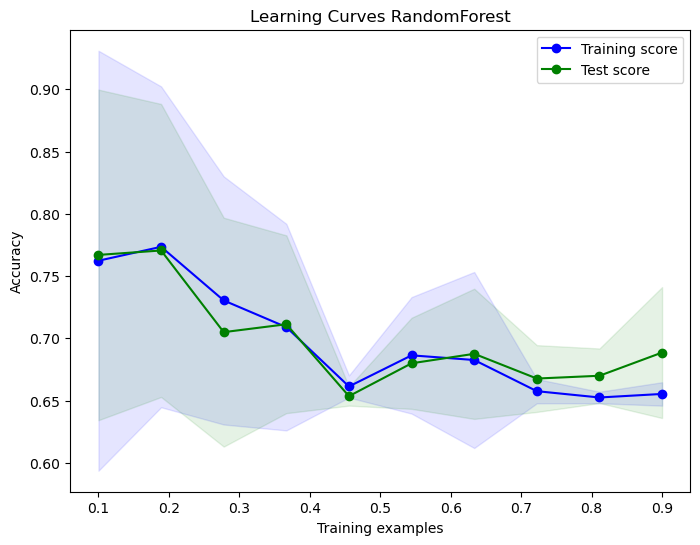

Train size: 0.1
             Mean training score: 0.936
             Standard deviation: 0.02154
Train size: 0.18888888888888888
             Mean training score: 0.88883
             Standard deviation: 0.04151
Train size: 0.2777777777777778
             Mean training score: 0.88195
             Standard deviation: 0.03895
Train size: 0.3666666666666667
             Mean training score: 0.8224
             Standard deviation: 0.05753
Train size: 0.4555555555555556
             Mean training score: 0.81121
             Standard deviation: 0.04868
Train size: 0.5444444444444445
             Mean training score: 0.79908
             Standard deviation: 0.04293
Train size: 0.6333333333333333
             Mean training score: 0.78657
             Standard deviation: 0.02717
Train size: 0.7222222222222222
             Mean training score: 0.74557
             Standard deviation: 0.02565
Train size: 0.8111111111111111
             Mean training score: 0.75314
             Standard deviation:

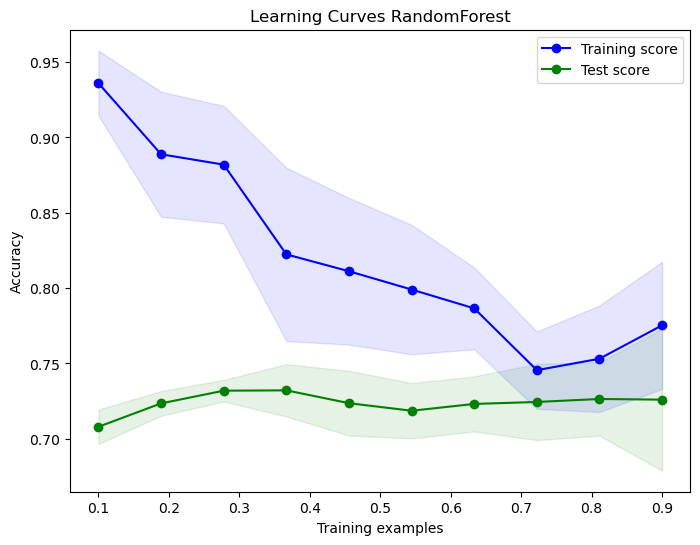

Train size: 0.1
             Mean training score: 0.87895
             Standard deviation: 0.03803
Train size: 0.18888888888888888
             Mean training score: 0.90722
             Standard deviation: 0.02065
Train size: 0.2777777777777778
             Mean training score: 0.85038
             Standard deviation: 0.0314
Train size: 0.3666666666666667
             Mean training score: 0.87265
             Standard deviation: 0.02792
Train size: 0.4555555555555556
             Mean training score: 0.87064
             Standard deviation: 0.02758
Train size: 0.5444444444444445
             Mean training score: 0.87025
             Standard deviation: 0.01504
Train size: 0.6333333333333333
             Mean training score: 0.8764
             Standard deviation: 0.00949
Train size: 0.7222222222222222
             Mean training score: 0.87395
             Standard deviation: 0.01709
Train size: 0.8111111111111111
             Mean training score: 0.88623
             Standard deviation

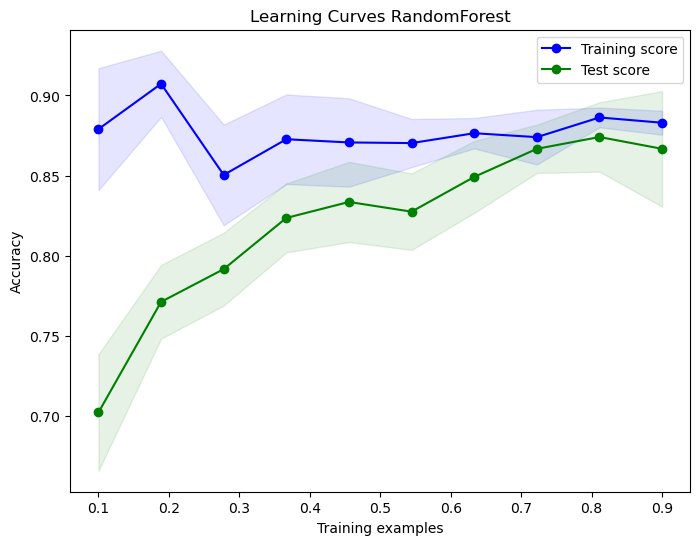

Train size: 0.1
             Mean training score: 0.98077
             Standard deviation: 0.0258
Train size: 0.18888888888888888
             Mean training score: 0.96939
             Standard deviation: 0.02922
Train size: 0.2777777777777778
             Mean training score: 0.97534
             Standard deviation: 0.01475
Train size: 0.3666666666666667
             Mean training score: 0.98438
             Standard deviation: 0.0163
Train size: 0.4555555555555556
             Mean training score: 0.99
             Standard deviation: 0.00726
Train size: 0.5444444444444445
             Mean training score: 0.98951
             Standard deviation: 0.00469
Train size: 0.6333333333333333
             Mean training score: 0.99281
             Standard deviation: 0.00448
Train size: 0.7222222222222222
             Mean training score: 0.98947
             Standard deviation: 0.00408
Train size: 0.8111111111111111
             Mean training score: 0.99159
             Standard deviation: 0

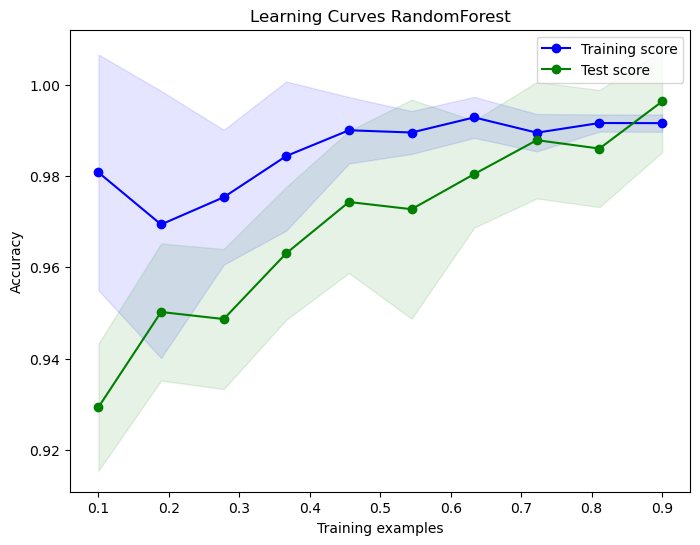

Train size: 0.1
             Mean training score: 0.78
             Standard deviation: 0.1249
Train size: 0.18888888888888888
             Mean training score: 0.97222
             Standard deviation: 0.05693
Train size: 0.2777777777777778
             Mean training score: 0.97037
             Standard deviation: 0.03229
Train size: 0.3666666666666667
             Mean training score: 0.99167
             Standard deviation: 0.01273
Train size: 0.4555555555555556
             Mean training score: 0.98667
             Standard deviation: 0.01474
Train size: 0.5444444444444445
             Mean training score: 0.98148
             Standard deviation: 0.02191
Train size: 0.6333333333333333
             Mean training score: 0.99206
             Standard deviation: 0.01065
Train size: 0.7222222222222222
             Mean training score: 0.99306
             Standard deviation: 0.00694
Train size: 0.8111111111111111
             Mean training score: 0.98765
             Standard deviation: 

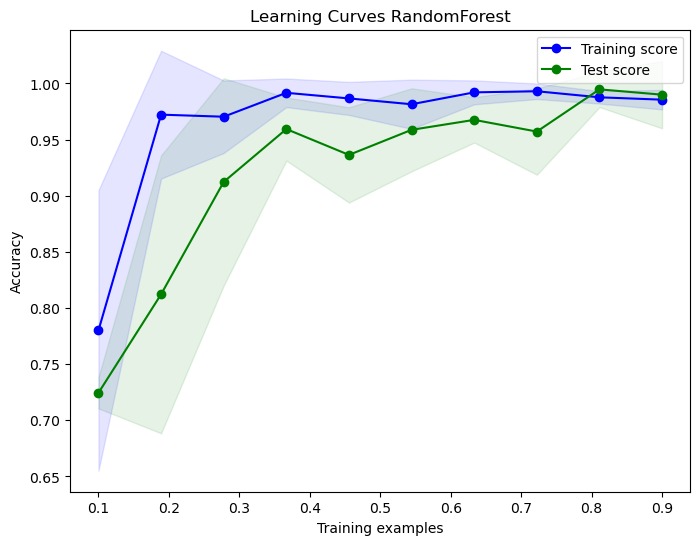

Train size: 0.1
             Mean training score: 0.91111
             Standard deviation: 0.05666
Train size: 0.18888888888888888
             Mean training score: 0.89706
             Standard deviation: 0.04412
Train size: 0.2777777777777778
             Mean training score: 0.904
             Standard deviation: 0.02332
Train size: 0.3666666666666667
             Mean training score: 0.91212
             Standard deviation: 0.0309
Train size: 0.4555555555555556
             Mean training score: 0.90732
             Standard deviation: 0.01654
Train size: 0.5444444444444445
             Mean training score: 0.9
             Standard deviation: 0.01814
Train size: 0.6333333333333333
             Mean training score: 0.9114
             Standard deviation: 0.01268
Train size: 0.7222222222222222
             Mean training score: 0.91308
             Standard deviation: 0.02094
Train size: 0.8111111111111111
             Mean training score: 0.90822
             Standard deviation: 0.02

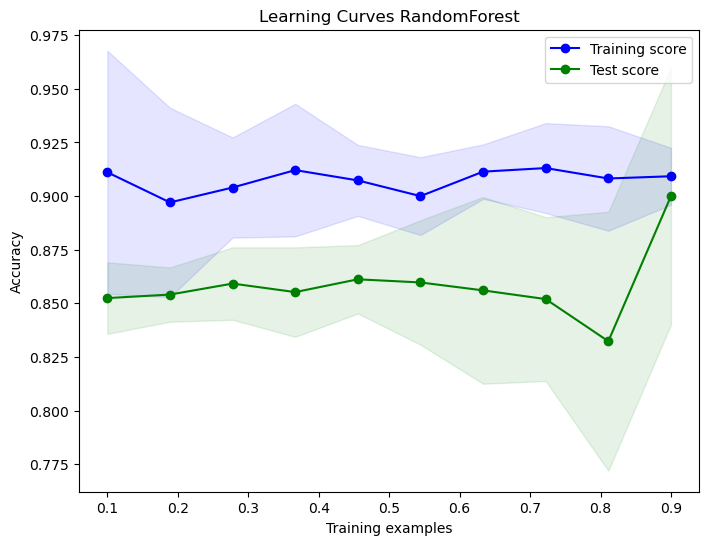

Train size: 0.1
             Mean training score: 0.74444
             Standard deviation: 0.11167
Train size: 0.18888888888888888
             Mean training score: 0.90556
             Standard deviation: 0.06597
Train size: 0.2777777777777778
             Mean training score: 0.92692
             Standard deviation: 0.04695
Train size: 0.3666666666666667
             Mean training score: 0.92286
             Standard deviation: 0.03625
Train size: 0.4555555555555556
             Mean training score: 0.95455
             Standard deviation: 0.02689
Train size: 0.5444444444444445
             Mean training score: 0.95192
             Standard deviation: 0.0215
Train size: 0.6333333333333333
             Mean training score: 0.95902
             Standard deviation: 0.01511
Train size: 0.7222222222222222
             Mean training score: 0.94571
             Standard deviation: 0.01666
Train size: 0.8111111111111111
             Mean training score: 0.94487
             Standard deviatio

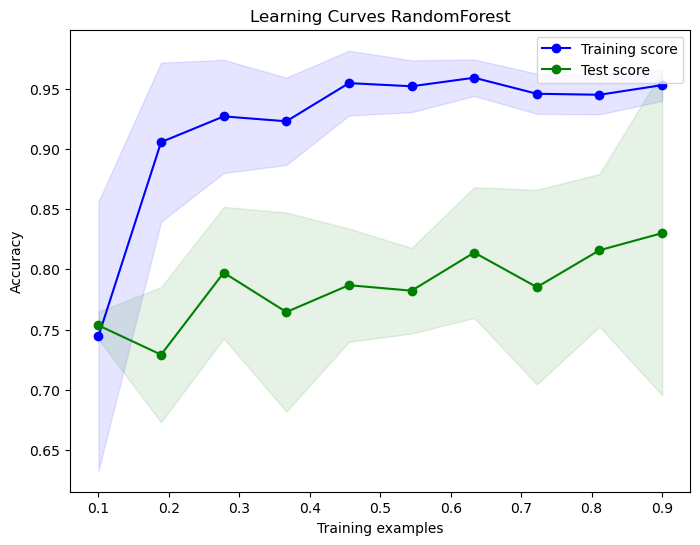

Train size: 0.1
             Mean training score: 0.7
             Standard deviation: 0.16125
Train size: 0.18888888888888888
             Mean training score: 0.58889
             Standard deviation: 0.05092
Train size: 0.2777777777777778
             Mean training score: 0.96154
             Standard deviation: 0.03846
Train size: 0.3666666666666667
             Mean training score: 0.97778
             Standard deviation: 0.02722
Train size: 0.4555555555555556
             Mean training score: 0.94091
             Standard deviation: 0.05
Train size: 0.5444444444444445
             Mean training score: 0.94815
             Standard deviation: 0.04124
Train size: 0.6333333333333333
             Mean training score: 0.95161
             Standard deviation: 0.02974
Train size: 0.7222222222222222
             Mean training score: 0.94444
             Standard deviation: 0.02152
Train size: 0.8111111111111111
             Mean training score: 0.94
             Standard deviation: 0.0229

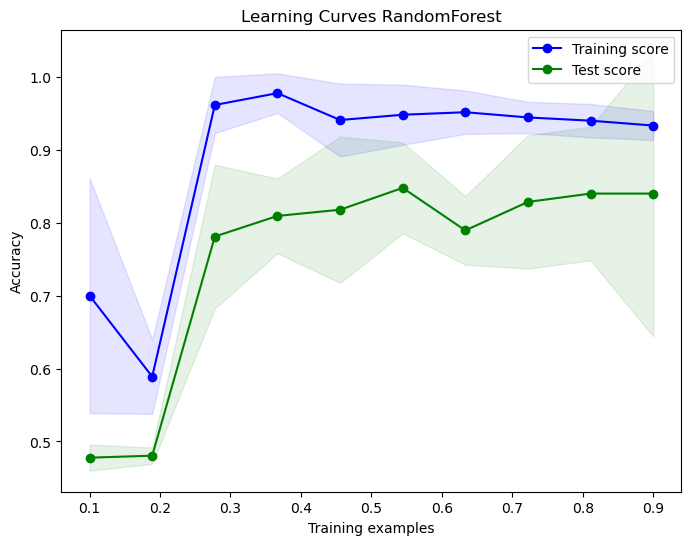

Train size: 0.1
             Mean training score: 0.9
             Standard deviation: 0.15275
Train size: 0.18888888888888888
             Mean training score: 0.74286
             Standard deviation: 0.13997
Train size: 0.2777777777777778
             Mean training score: 0.75
             Standard deviation: 0.1118
Train size: 0.3666666666666667
             Mean training score: 0.86154
             Standard deviation: 0.10205
Train size: 0.4555555555555556
             Mean training score: 0.87647
             Standard deviation: 0.06681
Train size: 0.5444444444444445
             Mean training score: 0.895
             Standard deviation: 0.05679
Train size: 0.6333333333333333
             Mean training score: 0.90417
             Standard deviation: 0.04583
Train size: 0.7222222222222222
             Mean training score: 0.92593
             Standard deviation: 0.03704
Train size: 0.8111111111111111
             Mean training score: 0.92333
             Standard deviation: 0.0335

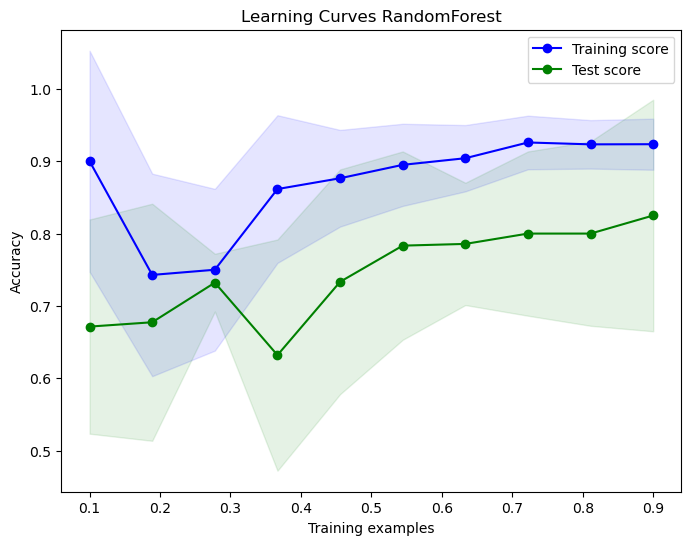

Train size: 0.1
             Mean training score: 0.93333
             Standard deviation: 0.11547
Train size: 0.18888888888888888
             Mean training score: 0.73448
             Standard deviation: 0.22297
Train size: 0.2777777777777778
             Mean training score: 0.9
             Standard deviation: 0.12308
Train size: 0.3666666666666667
             Mean training score: 0.73158
             Standard deviation: 0.15295
Train size: 0.4555555555555556
             Mean training score: 0.75775
             Standard deviation: 0.19817
Train size: 0.5444444444444445
             Mean training score: 0.65233
             Standard deviation: 0.11457
Train size: 0.6333333333333333
             Mean training score: 0.672
             Standard deviation: 0.12424
Train size: 0.7222222222222222
             Mean training score: 0.65175
             Standard deviation: 0.11518
Train size: 0.8111111111111111
             Mean training score: 0.71797
             Standard deviation: 0.

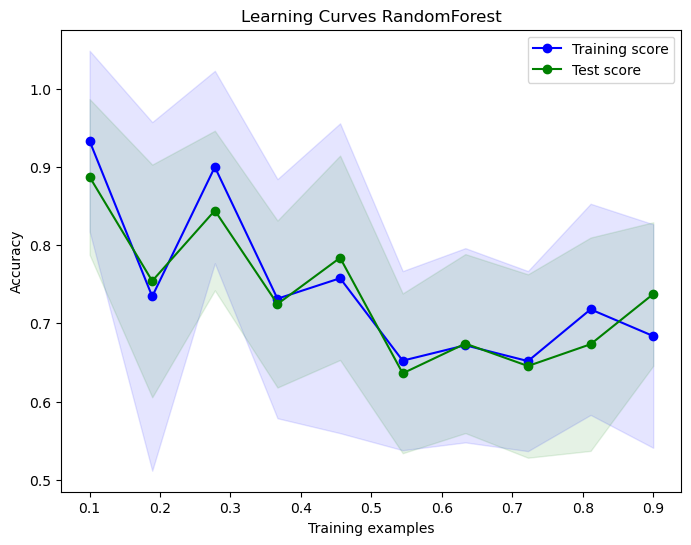

In [14]:
for dataset_id in dataset_ids:
    dataset_data_entry = dataset_data[dataset_id]
    features = dataset_data_entry['features']
    targets = dataset_data_entry['targets']

    ab = RandomForestClassifier(max_depth=1000)
    plot_learning_curves(ab, features, targets, title="RandomForest")

We also decided to implement `plot_cm()` in order to attain a confusion matrix for each of the fitted models.

In [15]:
def plot_cm(model_fit, X_test, y_test, ds_id):
    y_pred = model_fit.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix - Dataset {}".format(ds_id))

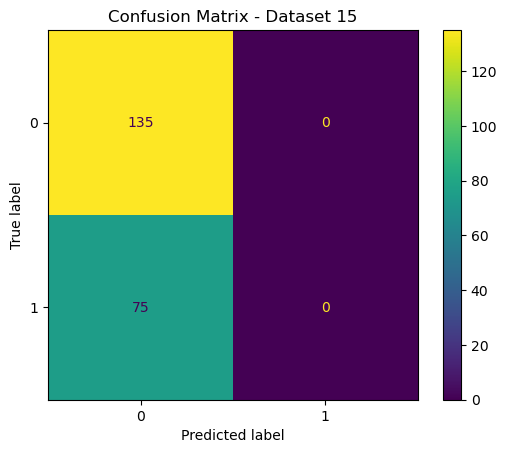

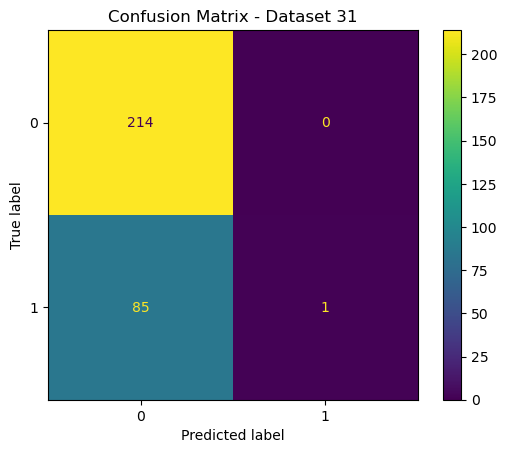

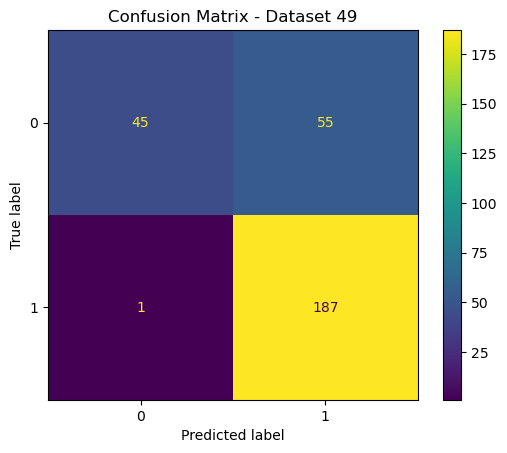

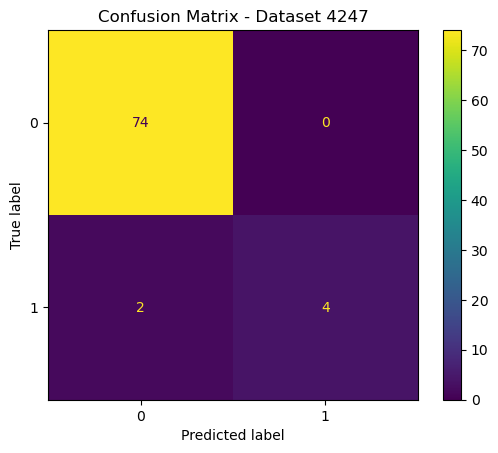

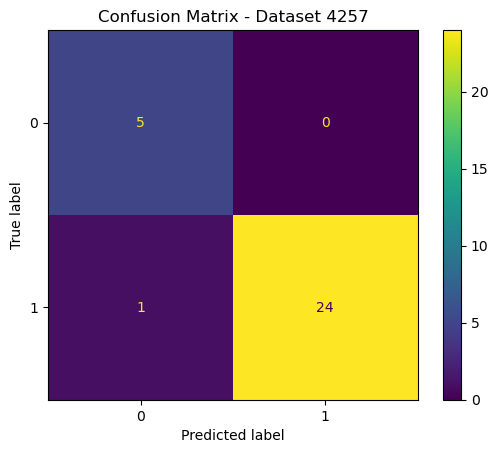

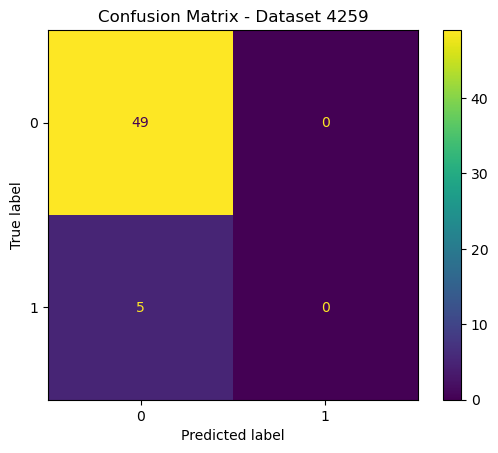

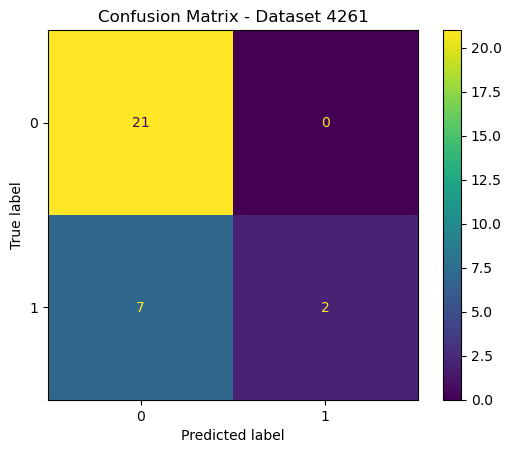

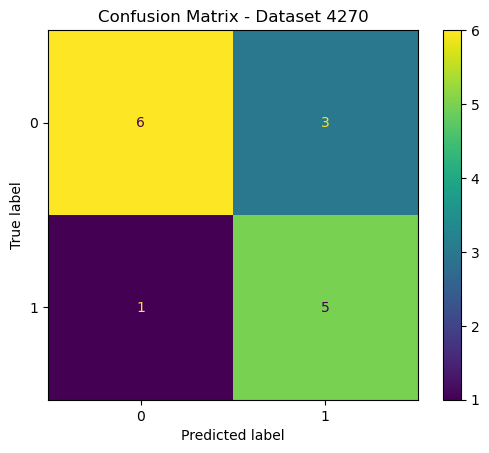

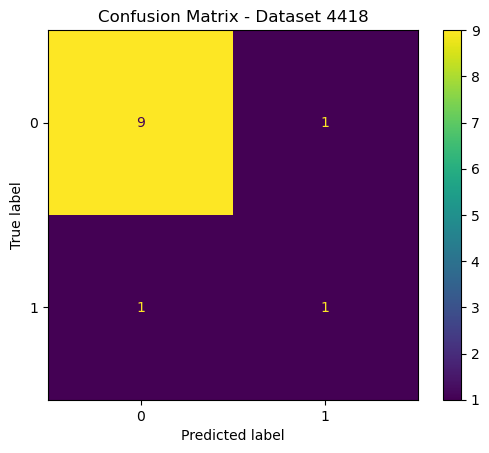

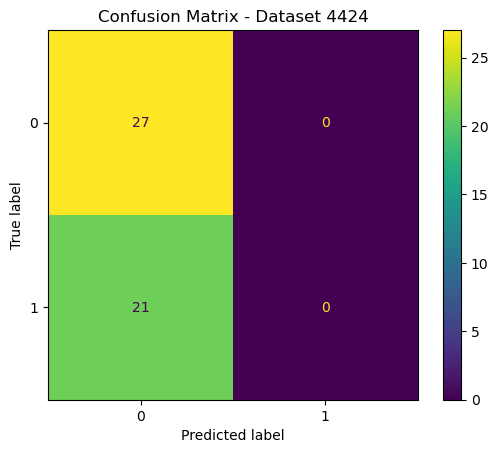

In [16]:
for dataset_id in dataset_ids:
    dataset_data_entry = dataset_data[dataset_id]
    features = dataset_data_entry['features']
    targets = dataset_data_entry['targets'] 
    models = ['RandomForest_Original']
    result = run_cv(features, targets, models)
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=0)
    random_forest = RandomForestClassifier(max_depth=1000)
    random_forest.fit(X_train, y_train)
    plot_cm(random_forest, X_test, y_test, dataset_id) 

Since the ROC Curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) for various threshold values, it allows us to, once again, have a visual interpretation of RandomForest's performance.   

In [17]:
def plot_roc_curve(y_true, y_pred, dataset_id):
    if len(np.unique(y_true)) > 2:
        print("Formato multiclasse não suportado. A curva ROC não será plotada.")
        return

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - Dataset ID: {dataset_id}')
    plt.legend(loc="lower right")
    plt.show()

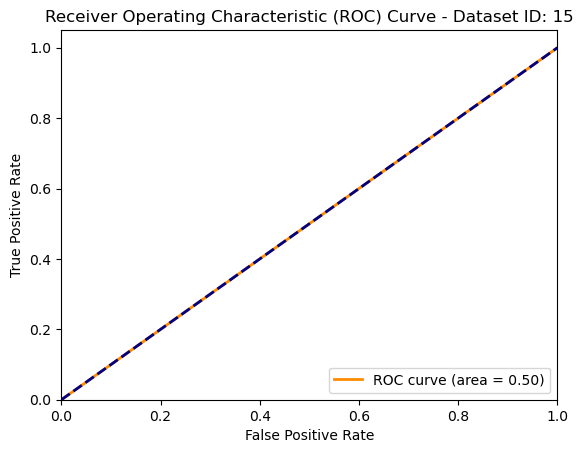

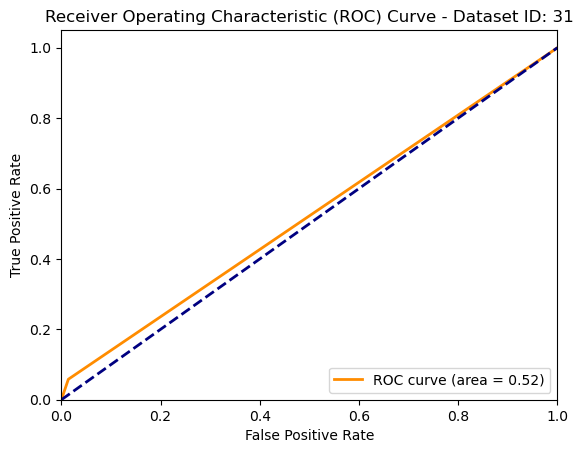

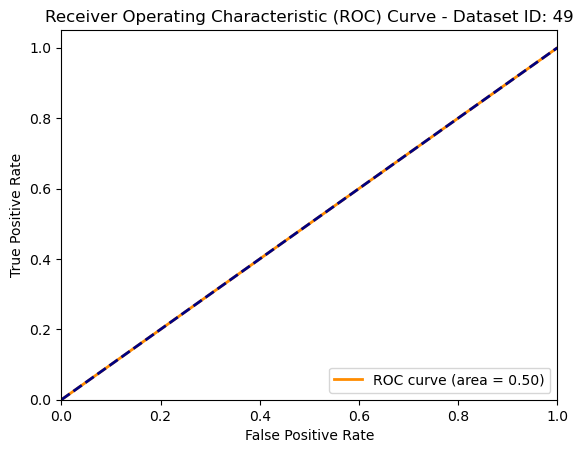

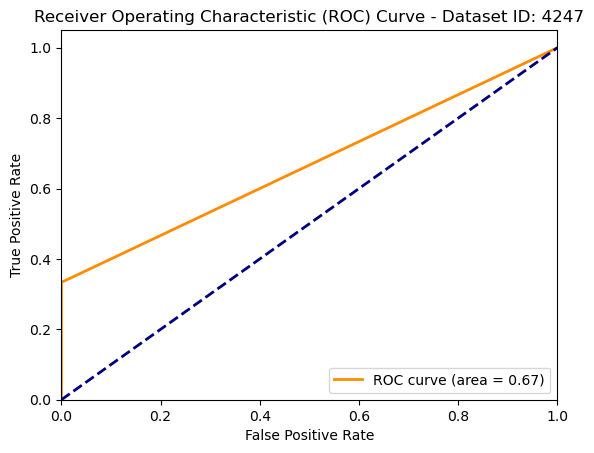

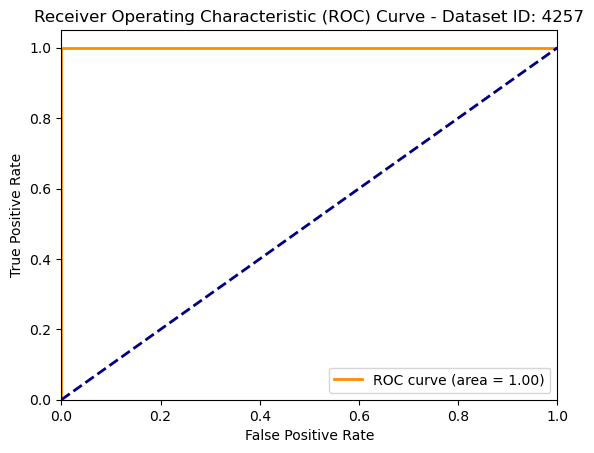

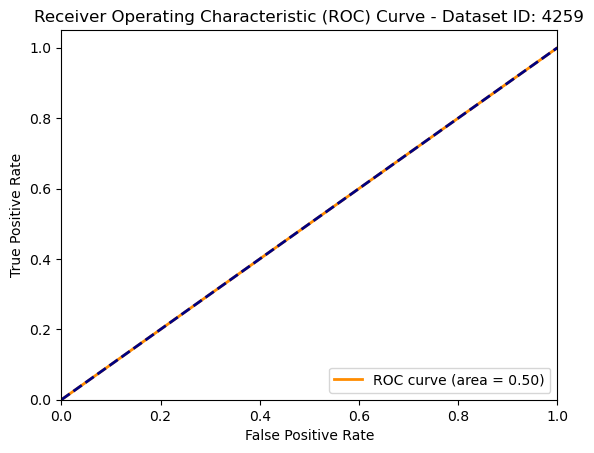

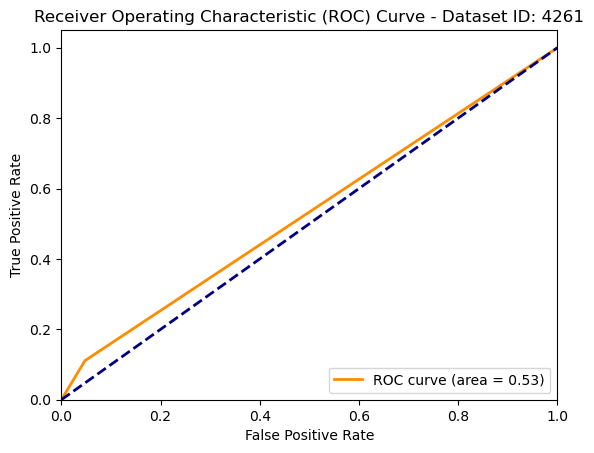

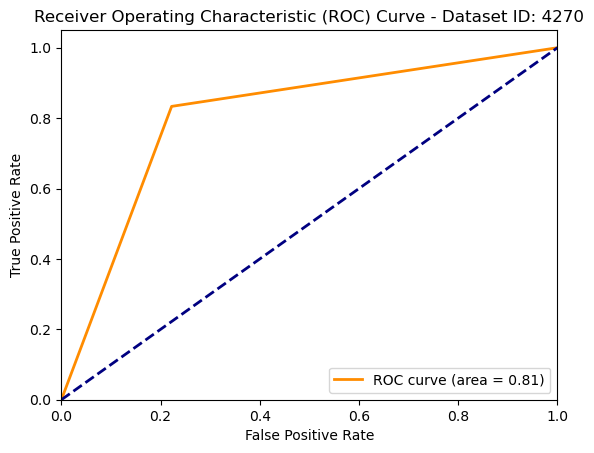

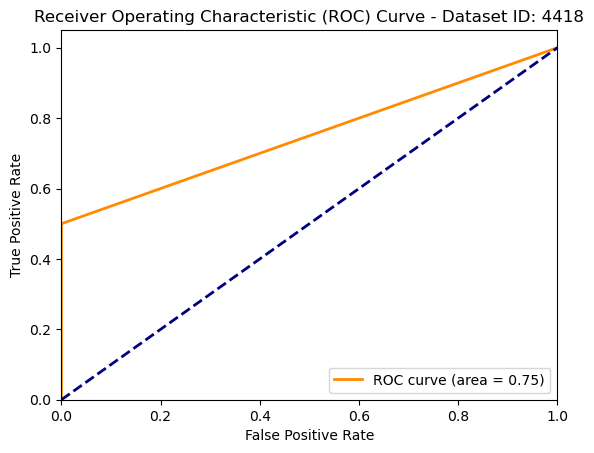

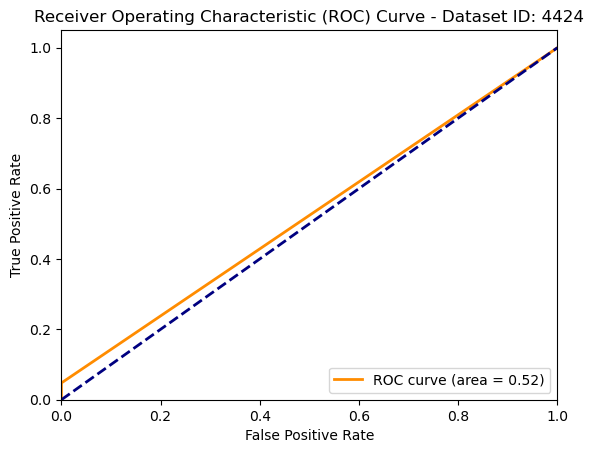

In [18]:
for dataset_id in dataset_ids:
    dataset_data_entry = dataset_data[dataset_id]
    features = dataset_data_entry['features']
    targets = dataset_data_entry['targets'] 
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=0)
    random_forest = RandomForestClassifier(max_depth=1000)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    plot_roc_curve(y_test, y_pred, dataset_id)

### Comparison of base algorithm and modified ones

Definition of the models:
- `RandomForest_Original` is the default RandomForest classifier.
- `RandomForest_1` is 
- `RandomForest_2` is 


In [19]:
random_forests = {
    'RandomForest_Original': RandomForestClassifier,
    'RandomForest_1': RandomForestClassifierDifferent,
    'RandomForest_2': RandomForestClassifierDifferent2
}

In [20]:
def treino_casos(features, targets):
    X = features
    y = targets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    random_forest= RandomForestClassifier(max_depth=1000)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix (y_test, y_pred)
    return accuracy,y_test,y_pred,X_test,random_forest,X,y,y_train, cm
def treino_casos_alterado(features, targets):
    X = features
    y = targets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    random_forest = RandomForestClassifierDifferent(max_depth = 1000, y_test = y_test)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix (y_test, y_pred)
    return accuracy, y_test, y_pred, X_test, random_forest, X, y, y_train, cm
def treino_casos_alterado2(features, targets):
    X = features
    y = targets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    random_forest = RandomForestClassifierDifferent2(max_depth=1000)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix (y_test, y_pred)
    return accuracy, y_test, y_pred, X_test, random_forest, X, y, y_train, cm

In [21]:
def estatisticas(features,targets,caso):
    if caso ==1:
        print("RandomForest Caso Base")
        accuracy,y_test,predictions,X_test,random_forest,X,y,y_train,mc = treino_casos(features, targets)
    if caso == 2:
        print("RandomForest 1")
        accuracy,y_test,predictions,X_test,random_forest,X,y,y_train,mc= treino_casos_alterado(features, targets)
    if caso == 3:
        print("RandomForest 2")
        accuracy,y_test,predictions,X_test,random_forest,X,y,y_train,mc= treino_casos_alterado2(features, targets)

    precision = precision_score(y_test, predictions, average='weighted', zero_division=1)
    recall = recall_score(y_test, predictions, average='weighted')
    
    f1 = f1_score(y_test, predictions, average='weighted')
    print("F1-score:", f1)
        
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

In [22]:
for dataset_id in dataset_ids:    
    dataset_data_entry = dataset_data[dataset_id]
    features = dataset_data_entry['features']
    targets = dataset_data_entry['targets']
    
    print(f"Dataset {dataset_id}:")
    casos=[1,2,3]
    for caso in casos:
        estatisticas(features,targets,caso)
        print("-" * 50)


Dataset 15:
RandomForest Caso Base
F1-score: 0.6414041885166505
Accuracy: 0.7095238095238096
Precision: 0.7788567746686303
Recall: 0.7095238095238096
--------------------------------------------------
RandomForest 1
F1-score: 0.5031055900621119
Accuracy: 0.6428571428571429
Precision: 0.770408163265306
Recall: 0.6428571428571429
--------------------------------------------------
RandomForest 2
F1-score: 0.5031055900621119
Accuracy: 0.6428571428571429
Precision: 0.770408163265306
Recall: 0.6428571428571429
--------------------------------------------------
Dataset 31:
RandomForest Caso Base
F1-score: 0.6241220043572985
Accuracy: 0.7266666666666667
Precision: 0.8023873873873875
Recall: 0.7266666666666667
--------------------------------------------------
RandomForest 1
F1-score: 0.6145825951016154
Accuracy: 0.71
Precision: 0.6397327224131348
Recall: 0.71
--------------------------------------------------
RandomForest 2
F1-score: 0.593981841763943
Accuracy: 0.7133333333333334
Precision: 0.

`plot_cv` plots the results from 10-fold Cross Validation for the 3 used algorithms. We applied this function to each dataset.

In [23]:
def plot_cv(results_cv,metric='Accuracy', title="Cross-validation results for multiple algorithms in a single task"):
    fig, ax = plt.subplots()
    ax.boxplot(results_cv)
    ax.set_xticklabels(results_cv.columns)
    ax.set_ylabel(metric)
    ax.set_title(title)
    plt.show()

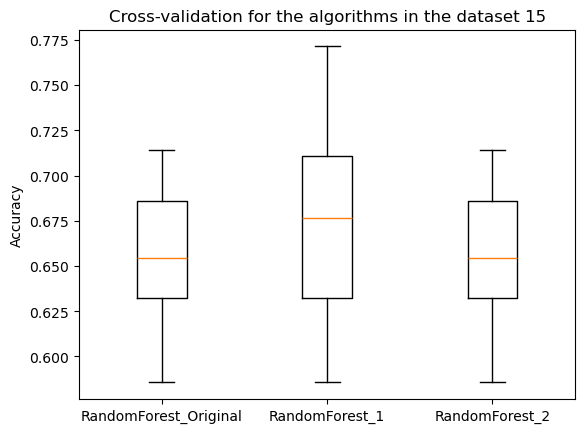

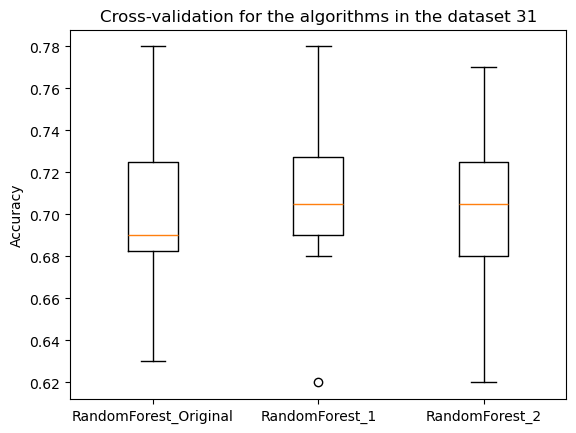

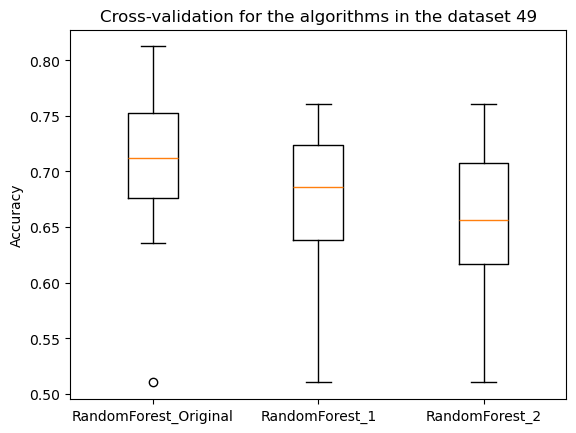

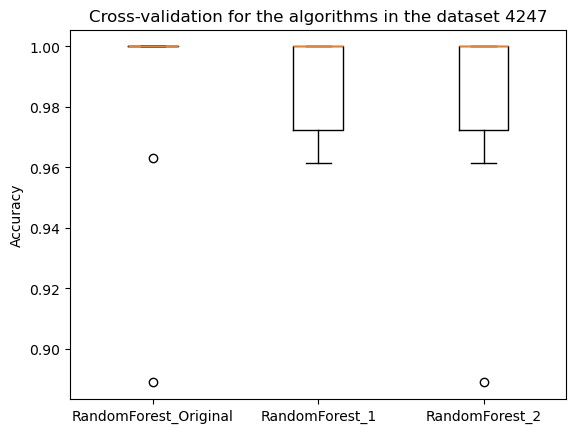

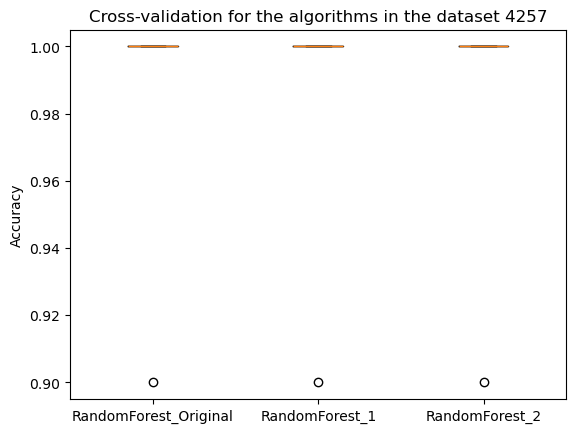

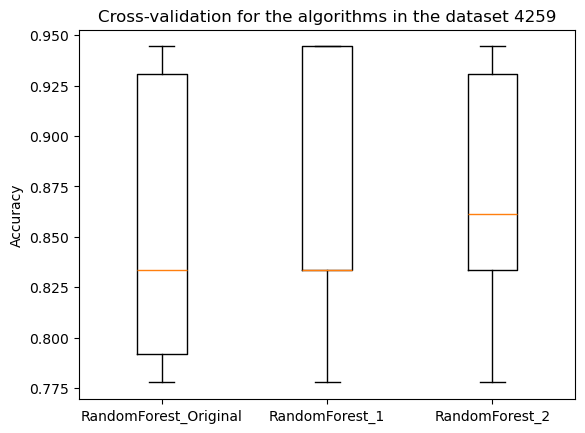

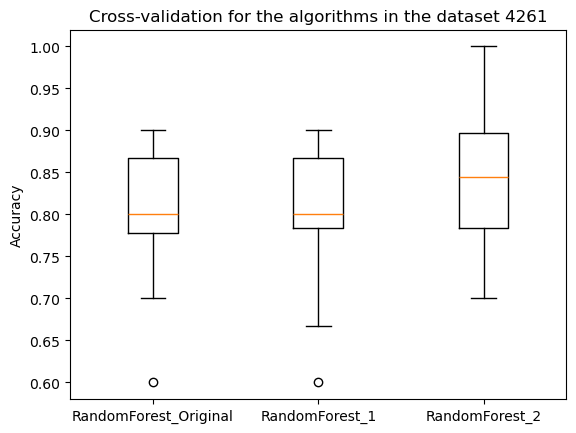

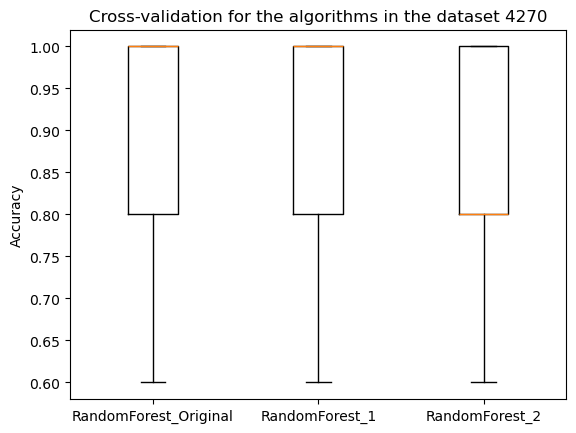

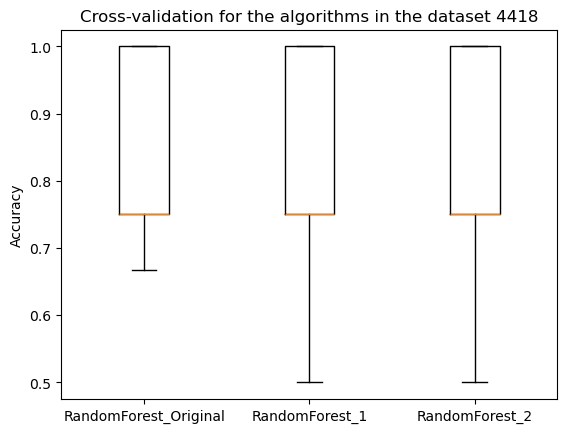

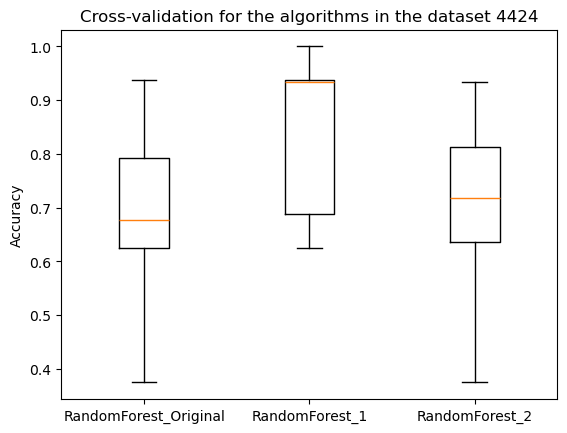

In [24]:
for dataset_id in dataset_ids:
    dataset_data_entry = dataset_data[dataset_id]
    features = dataset_data_entry['features']
    targets = dataset_data_entry['targets']  
    models =['RandomForest_Original','RandomForest_1','RandomForest_2']
    results = run_cv(features, targets, models)
    plot_cv(results, title=f"Cross-validation for the algorithms in the dataset {dataset_id}")

To have a better understanding of how effective our changes were, it's possible to see in a table below the accuracy obtained from all of the datasets with all of the new models (using the previously mentioned `run_cv` function).

In [25]:
def run_cv_per_dataset(datasets, algs):
    table = pd.DataFrame()
    for dataset_id in datasets:
        dataset_data_entry = dataset_data[dataset_id]
        features = dataset_data_entry['features']
        targets = dataset_data_entry['targets']  
        result_ds = run_cv(features, targets, algs, means_only=True)
        table = pd.concat([table, result_ds], ignore_index=True)
    
    return table

In [26]:
models =['RandomForest_Original','RandomForest_1','RandomForest_2']
table= run_cv_per_dataset(dataset_ids, models)
table

,RandomForest_Original,RandomForest_1,RandomForest_2
0,0.655217,0.680932,0.658075
1,0.706000,0.700000,0.701000
2,0.653454,0.653454,0.653454
3,0.985185,0.984900,0.985185
4,0.950000,0.990000,0.980000
5,0.861111,0.866667,0.866667
6,0.784444,0.804444,0.826667
7,0.880000,0.900000,0.820000
8,0.841667,0.875000,0.816667
9,0.672083,0.778333,0.659583


In [29]:
mean_results = table.mean(axis=0)

print("Average results for each metric:")
print(mean_results)

Average results for each metric:
RandomForest_Original    0.798916
RandomForest_1           0.823373
RandomForest_2           0.796730
dtype: float64


It's also possible to analyse their performance compared to each other by ranking the models. Below there's another table where each line (0-9) is a dataset and the respective collumn shows the models' position in ranking.  
Line 10 holds the average rank for each classifier.

In [27]:
def get_ranks(estimates_df, asc=False):
    if not estimates_df.applymap(np.isreal).all().all():
        raise ValueError("The DataFrame should only contain numeric values.")

    results_rank = estimates_df.rank(axis=1, ascending=asc, method='min')
    
    results_rank.loc[len(results_rank)] = results_rank.mean()
    
    return results_rank

In [28]:
table_ranks = get_ranks(table)
table_ranks

C:\Users\isabe\AppData\Local\Temp\ipykernel_89120\184399553.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not estimates_df.applymap(np.isreal).all().all():


,RandomForest_Original,RandomForest_1,RandomForest_2
0,3.0,1.0,2.0
1,1.0,3.0,2.0
2,1.0,1.0,1.0
3,1.0,3.0,1.0
4,3.0,1.0,2.0
5,3.0,1.0,1.0
6,3.0,2.0,1.0
7,2.0,1.0,3.0
8,2.0,1.0,3.0
9,2.0,1.0,3.0


Finally, we ran a Friedman test to check whether all of the models could be considered equivalent (and had equal rankings across the tasks).  
Considering that the p-value is greater than alpha, we can accept the hypothesis of the algorithms being equivalent with a significancy level of 5%.

In [30]:
def multiple_comp(mean_results,estimates_df,alpha=0.05):
    fvalue, pvalue = ss.friedmanchisquare(*[estimates_df[alg] for alg in estimates_df])
    print(f'p-value = {pvalue:.3f}')
    if pvalue >= alpha:
        print(f'There is no significant difference in performance among the algorithms')
        pairedcomp = sp.posthoc_nemenyi_friedman(estimates_df)
        conover_pairedcomp = sp.posthoc_conover_friedman(estimates_df)
        plt.figure(figsize=(10, 2), dpi=100)
        plt.title('Critical difference diagram of average score ranks')
        critical_diagram = sp.critical_difference_diagram(mean_results, conover_pairedcomp)
        return pairedcomp,None, critical_diagram 

    print(f'There is a significant difference in performance among the algorithms')
    pairedcomp = sp.posthoc_nemenyi_friedman(estimates_df)
    conover_pairedcomp = sp.posthoc_conover_friedman(estimates_df)
    plt.figure(figsize=(10, 2), dpi=100)
    plt.title('Critical difference diagram of average score ranks')
    critical_diagram = sp.critical_difference_diagram(mean_results, conover_pairedcomp)
    return(pairedcomp) , conover_pairedcomp, critical_diagram 

c:\Users\isabe\anaconda3\envs\ac\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


p-value = 0.318
There is no significant difference in performance among the algorithms


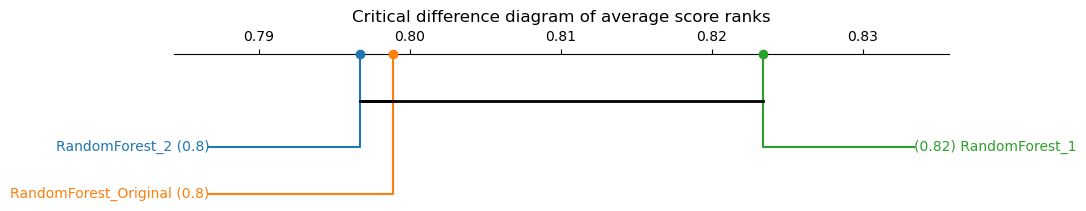

In [31]:
paired_comparision, conover_pairedcomp, critical_diagram  = multiple_comp(mean_results,table)

In [32]:
def plot_multiple_comp(pairedcomp):
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',\
    'clip_on': False, 'square': True, \
    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    sp.sign_plot(pairedcomp,**heatmap_args)

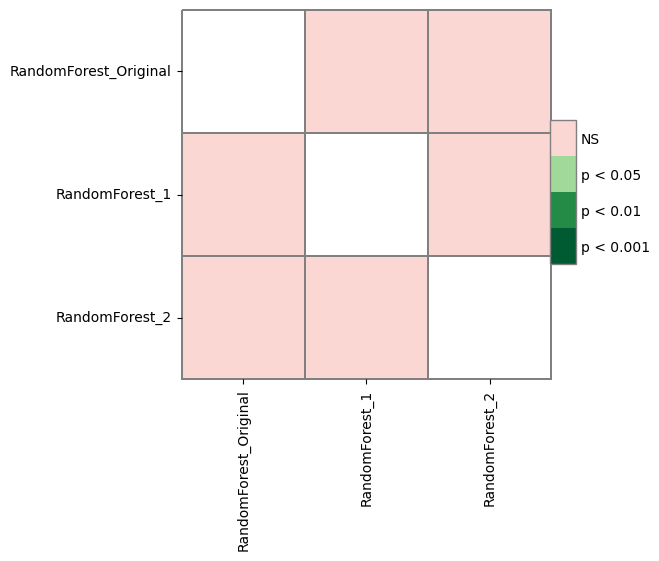

In [33]:
plot_multiple_comp(paired_comparision)